# Robot Long Jump

Solution to the [Robot Long Jump puzzle](https://www.janestreet.com/puzzles/robot-long-jump-index/).

Featured on the leaderboard (name: Guillaume Baquiast).

## Problem description
Great news! The variety of robotic competition continues to grow at breakneck pace! Most recently, head-to-head long jump contests have been all the rage.

These contests consist of rounds in which each robot has a single attempt to score. In an attempt, a robot speeds down the running track (modeled as the numberline) from 0, the starting line, to 1, the takeoff point. A robot moves along this track by drawing a real number uniformly from [0,1] and adding it to the robot’s current position. After each of these advances, the robot must decide whether to jump or wait. If a robot crosses the takeoff point (at 1) before jumping its attempt receives a score of 0. If the robot jumps before crossing 1, it draws one final real number from [0,1] and adds it to its current position, and this final sum is the score of the attempt.

In a head-to-head contest, the two robots each have a single attempt without knowing the other’s result. In the case that they tie (typically because they both scored 0), that round is discarded and a new round begins. As soon as one robot scores higher than the other on the same round, that robot is declared the winner!

Assume both robots are programmed to optimize their probability of winning and are aware of each other’s strategies. You are just sitting down to watch a match’s very first attempt (of the first round, which may or may not end up being discarded). What is the probability that this attempt scores 0? Give this probability as a decimal rounded to 9 digits past the decimal point.

## Approach
Assumption: strategies are to jump when the robot passes a certain threshold
1. Compute the probability of each position throughout the different turns of the game, depending on the chosen threshold (pen and paper derivation, validated using Monte Carlo simulations)
2. Deduce the probability of the final score of the game, using sympy to simplify the maths
3. Find the Nash equilibirum, in which both robots maximise the probability of winning, given the strategy of the other robot

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import sympy as sp
sp.init_printing()

# 1. Compute the probability of each position

In [3]:
# Monte Carlo functions
def get_robot_decision(x, threshold):
    if x > threshold:
        return "jump"
    else:
        return "draw"

    
def simulate_game(threshold):
    game_over = False
    curr_dist = 0
    
    while not game_over:
        robot_decision = get_robot_decision(curr_dist, threshold)
        if robot_decision == "jump":
            curr_dist += np.random.uniform(low=0.0, high=1.0)
            game_over = True
            score = curr_dist
        else:
            curr_dist += np.random.uniform(low=0.0, high=1.0)
            if curr_dist > 1:
                game_over = True
                score = 0
    
    return score


def monte_carlo(n_simul, threshold):
    simul_results = []
    for _ in range(n_simul):
        simul_results.append(simulate_game(threshold))
    
    return simul_results


def simulate_n_games_until_round(threshold, n_games, n_rounds):
    dict_status_per_game = {i: ("playing", 0) for i in range(n_games)}
    dict_nb_status_per_round = dict()
    
    for index_round in range(n_rounds+1):
        dict_nb_status_per_round[index_round] = {
            "playing - x < th": 0,
            "playing - th<x<1": 0,
            "jumped": 0,
            "failed": 0,
        }
        
        for game_id, game_curr_status in dict_status_per_game.items():
            if (game_curr_status[0] == "playing") & (game_curr_status[1] <= threshold):
                # increment counter
                dict_nb_status_per_round[index_round]["playing - x < th"] += 1
                # update game status
                dict_status_per_game[game_id] = ("playing", game_curr_status[1]+np.random.uniform(low=0.0, high=1.0))
            
            if (game_curr_status[0] == "playing") & (threshold < game_curr_status[1]) & (game_curr_status[1] <= 1):
                # increment counter
                dict_nb_status_per_round[index_round]["playing - th<x<1"] += 1
                # update game status
                dict_status_per_game[game_id] = ("jumped", game_curr_status[1]+np.random.uniform(low=0.0, high=1.0))
            
            if ((game_curr_status[0] == "playing") & (1 < game_curr_status[1])) | (game_curr_status[0] == "failed"):
                # increment counter
                dict_nb_status_per_round[index_round]["failed"] += 1
                # update game status
                dict_status_per_game[game_id] = ("failed", game_curr_status[1])
            
            if game_curr_status[0] == "jumped":
                # increment counter
                dict_nb_status_per_round[index_round]["jumped"] += 1
    
    return dict_nb_status_per_round

In [4]:
nb_games = 1000000

(pd.DataFrame(simulate_n_games_until_round(threshold=.3, n_games=nb_games, n_rounds=10)) / nb_games * 100).round(2)

,0,1,2,3,4,5,6,7,8,9,10
playing - x < th,100.0,29.97,4.51,0.46,0.03,0.00,0.00,0.00,0.00,0.00,0.00
playing - th<x<1,0.0,70.03,20.97,3.16,0.32,0.02,0.00,0.00,0.00,0.00,0.00
jumped,0.0,0.00,70.03,91.00,94.16,94.48,94.51,94.51,94.51,94.51,94.51
failed,0.0,0.00,4.49,5.39,5.49,5.49,5.49,5.49,5.49,5.49,5.49


In [5]:
def theorical_proba_game(threshold, n_rounds):
    df = pd.DataFrame(columns=range(0, n_rounds+1), index=["playing - x < th", "playing - th<x<1", "jumped", "failed"])
    df.loc["playing - x < th"] = [threshold**k / math.factorial(k) for k in range(0, n_rounds+1)]
    df.loc["playing - th<x<1"] = [0] + [(1-threshold) * threshold**k / math.factorial(k) for k in range(0, n_rounds)]
    df.loc["jumped"] = [0] + df.loc["playing - th<x<1"].cumsum()[:-1].tolist()
    df.loc["failed"] = 1- (df.loc["playing - x < th"] + df.loc["playing - th<x<1"] + df.loc["jumped"])
    return df.astype("float")


def theoretical_end_game(threshold):
    return {
        "jump eventually": (1-threshold)*math.exp(threshold),
        "failed eventually": 1 - (1-threshold)*math.exp(threshold)
    }


def get_theoretical_end_proba(x, threshold):
    if x == 0:
        return 1 - (1-threshold)*math.exp(threshold)
    elif threshold < x <= 1:
        return math.exp(threshold) * (x - threshold)
    elif 1 < x <= (1+threshold):
        return math.exp(threshold) * (1 - threshold)
    elif (1+threshold) < x <= 2:
        return math.exp(threshold) * (2 - x)
    return 0


def get_cum_distribution(x, threshold):
    if 0 <= x < threshold:
        return 1 - (1-threshold)*math.exp(threshold)
    elif threshold <= x < 1:
        return 1 + math.exp(threshold)*((x**2+threshold**2)/2 - threshold*x + threshold - 1)
    elif 1 <= x < (1+threshold):
        return 1 + x*math.exp(threshold)*(1-threshold) + math.exp(threshold)*((1+threshold**2)/2 - 2 + threshold)
    elif (1+threshold) <= x <= 2:
        return 1 + math.exp(threshold)*(-x**2/2+2*x-2)
    else:
        return 0


print(theoretical_end_game(threshold=.3))
print(f"Proba of score {0} for threshold {.3}: {get_theoretical_end_proba(x=0, threshold=.3)}")

(theorical_proba_game(threshold=.3, n_rounds=10) * 100).round(2)

{'jump eventually': 0.9449011653032021, 'failed eventually': 0.05509883469679788}
Proba of score 0 for threshold 0.3: 0.05509883469679788


,0,1,2,3,4,5,6,7,8,9,10
playing - x < th,100.0,30.0,4.5,0.45,0.03,0.00,0.00,0.00,0.00,0.00,0.00
playing - th<x<1,0.0,70.0,21.0,3.15,0.31,0.02,0.00,0.00,0.00,0.00,0.00
jumped,0.0,0.0,70.0,91.00,94.15,94.46,94.49,94.49,94.49,94.49,94.49
failed,0.0,0.0,4.5,5.40,5.50,5.51,5.51,5.51,5.51,5.51,5.51


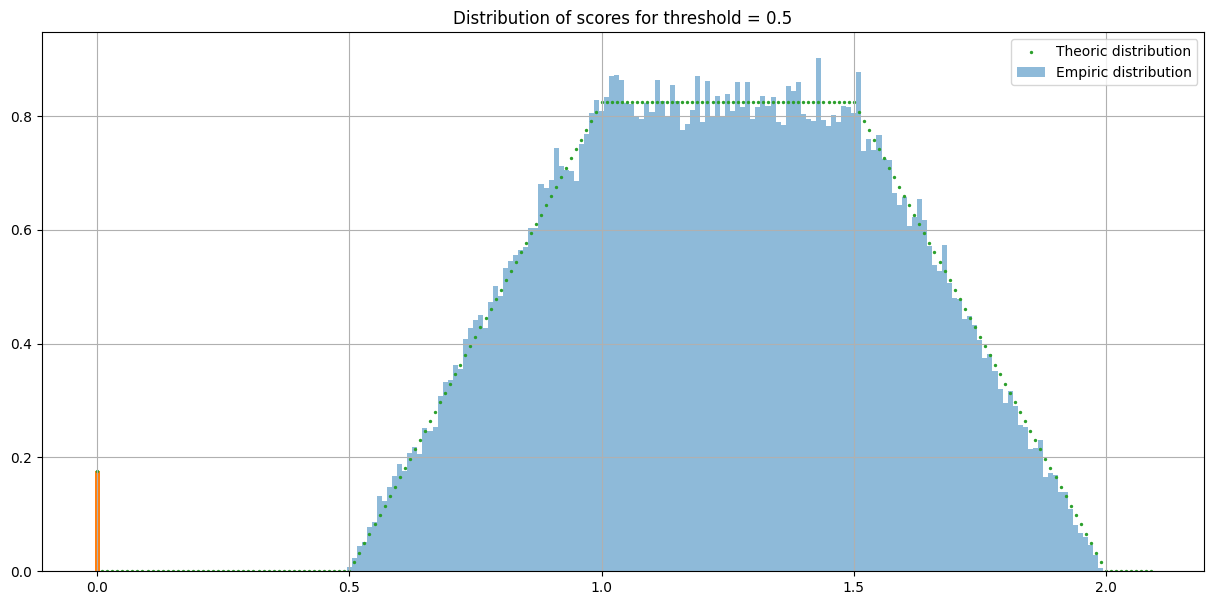

In [6]:
n_simul = 100000
threshold = .5

monte_carlo_res = pd.Series(monte_carlo(n_simul=n_simul, threshold=threshold))
p_score_0 = (monte_carlo_res == 0).sum() / n_simul
hist, bins = np.histogram(monte_carlo_res[monte_carlo_res > 0], bins=200, range=(0, 2), density=True)

plt.figure(figsize=(15, 7))
plt.bar(bins[:-1], hist.astype(np.float32) * (1 - p_score_0), width=(bins[1]-bins[0]), alpha=.5, label="Empiric distribution")
plt.bar(0, p_score_0, width=(bins[1]-bins[0]))
plt.scatter(
    np.arange(0, 2.1, .01),
    [get_theoretical_end_proba(x, threshold=threshold)  for x in np.arange(0, 2.1, .01)],
    label="Theoric distribution",
    s=2,
    
)
plt.title(f"Distribution of scores for threshold = {threshold}")
plt.legend()
plt.grid()
plt.show()

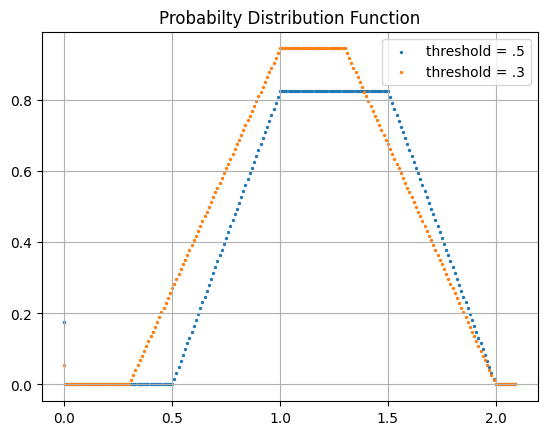

In [9]:
plt.scatter(
    np.arange(0, 2.1, .01),
    [get_theoretical_end_proba(x, threshold=.5)  for x in np.arange(0, 2.1, .01)],
    label="threshold = .5",
    s=2,  
)

plt.scatter(
    np.arange(0, 2.1, .01),
    [get_theoretical_end_proba(x, threshold=.3)  for x in np.arange(0, 2.1, .01)],
    label="threshold = .3",
    s=2,  
)

plt.title("Probabilty Distribution Function")
plt.legend()
plt.grid()
plt.show()

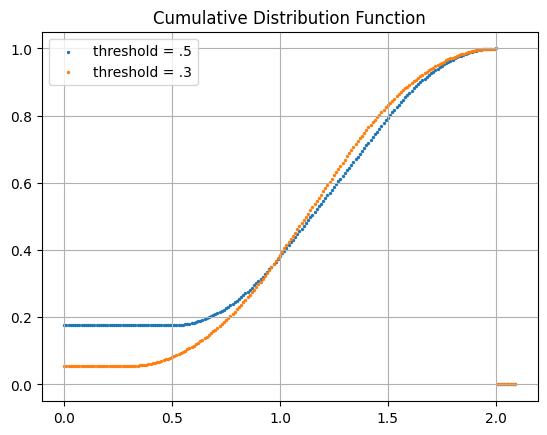

In [10]:
plt.scatter(
    np.arange(0, 2.1, .01),
    [get_cum_distribution(x, threshold=.5)  for x in np.arange(0, 2.1, .01)],
    label="threshold = .5",
    s=2,
)

plt.scatter(
    np.arange(0, 2.1, .01),
    [get_cum_distribution(x, threshold=.3)  for x in np.arange(0, 2.1, .01)],
    label="threshold = .3",
    s=2,
)

plt.title("Cumulative Distribution Function")
plt.legend()
plt.grid()
plt.show()

# 2. Deduce probability of game results

In [11]:
# Monte Carlo to verify the above

n_simul = 10000
threshold1=.5
threshold2=.5

def get_monte_carlo_outcomes(n_simul, threshold1, threshold2):
    proba_outcomes = {
        "p_draw": 0,
        "p_robot_2_wins": 0,
        "p_robot_1_wins": 0,
    }
    for _ in range(n_simul):
        score1 = simulate_game(threshold1)
        score2 = simulate_game(threshold2)
        
        if score1 == score2:
            proba_outcomes["p_draw"] += 1/n_simul
        elif score1 > score2:
            proba_outcomes["p_robot_1_wins"] += 1/n_simul
        else:
            proba_outcomes["p_robot_2_wins"] += 1/n_simul
    return proba_outcomes


def get_monte_carlo_outcomes_eventual(n_simul, threshold1, threshold2):
    proba_outcomes = {
        "p_robot_2_wins_eventually": 0,
        "p_robot_1_wins_eventually": 0,
    }
    for _ in range(n_simul):
        score1, score2 = 0, 0
        while (score1 == score2):
            score1 = simulate_game(threshold1)
            score2 = simulate_game(threshold2)
        if score1 > score2:
            proba_outcomes["p_robot_1_wins_eventually"] += 1/n_simul
        else:
            proba_outcomes["p_robot_2_wins_eventually"] += 1/n_simul
    return proba_outcomes

print("Monte Carlo")
print(get_monte_carlo_outcomes(n_simul, threshold1, threshold2))
print(get_monte_carlo_outcomes_eventual(n_simul, threshold1, threshold2))

Monte Carlo
{'p_draw': 0.027899999999999887, 'p_robot_2_wins': 0.4939999999999619, 'p_robot_1_wins': 0.47809999999996367}
{'p_robot_2_wins_eventually': 0.5034999999999609, 'p_robot_1_wins_eventually': 0.49649999999996164}


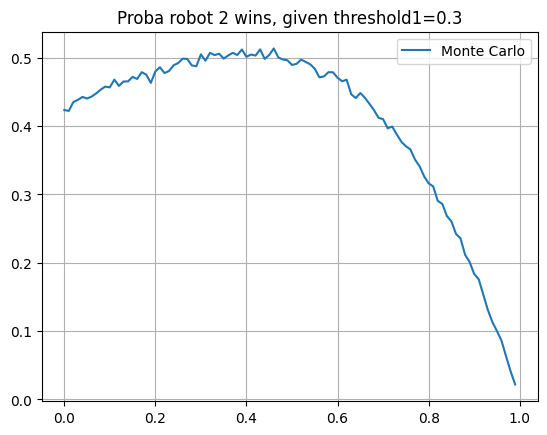

In [12]:
threshold1=.3

plt.plot(
    np.arange(0, 1, .01),
    [get_monte_carlo_outcomes(n_simul=10000, threshold1=threshold1, threshold2=threshold)["p_robot_2_wins"] for threshold in np.arange(0, 1, .01)],
    label="Monte Carlo"
)
plt.title(f"Proba robot 2 wins, given threshold1={threshold1}")
plt.grid()
plt.legend()
plt.show()

In [13]:
def get_formula_game_results_th1_lower_than_th2(lambdify=False):
    x, th1, th2 = sp.symbols('x th1 th2')
    
    # Proba draw
    proba_draw = (1-(1-th1)*sp.exp(th1))*(1-(1-th2)*sp.exp(th2))
    
    # Proba robot 2 wins /!\ only holds for th1 < th2
    expr1 = sp.simplify(
        (1-(1-th1)*sp.exp(th1))*(1-th2)*sp.exp(th2)
    )
    expr2 = sp.simplify(
        sp.factor(
            sp.integrate(
                sp.exp(th1)*(x-th1)*(1-th2)*sp.exp(th2),
                (x, th1, th2)
            )
        )
    )
    expr3 = sp.simplify(
        sp.integrate(
            -sp.exp(th1)*(x-th1)*sp.exp(th2)*(sp.Rational('1/2')*(x**2+th2**2)-th2*x+th2-1),
            (x, th2, 1)
        )
    )
    expr4 = sp.simplify(
        sp.integrate(
            -sp.exp(th1)*(1-th1)*sp.exp(th2)*(x-th2*x+sp.Rational('1/2')*(1+th2**2)-2+th2),
            (x, 1, 1+th1)
        )
    )
    expr5 = sp.simplify(
        sp.integrate(
            -sp.exp(th1)*(2-x)*sp.exp(th2)*(x-th2*x+sp.Rational('1/2')*(1+th2**2)-2+th2),
            (x, 1+th1, 1+th2)
        )
    )
    expr6 = sp.simplify(
        sp.integrate(
            -sp.exp(th1)*(2-x)*sp.exp(th2)*(2*x-sp.Rational('1/2')*x**2-2),
            (x, 1+th2, 2)
        )
    )
    proba_robot_2_wins = sp.simplify(
        expr1 + expr2 + expr3 + expr4 + expr5 + expr6
    )
    
    # Proba robot 1 wins
    proba_robot_1_wins = sp.simplify(1-proba_draw-proba_robot_2_wins)
    
    # Proba wins eventually
    proba_robot_2_wins_eventually = sp.simplify(proba_robot_2_wins / (1-proba_draw))
    proba_robot_1_wins_eventually = sp.simplify(proba_robot_1_wins / (1-proba_draw))
    
    if lambdify:
        return {
            "proba_draw_formula": sp.lambdify([th1, th2], proba_draw, "numpy"),
            "proba_robot_2_wins_this_round": sp.lambdify([th1, th2], proba_robot_2_wins, "numpy"),
            "proba_robot_1_wins_this_round": sp.lambdify([th1, th2], proba_robot_1_wins, "numpy"),
            "proba_robot_2_wins_eventually": sp.lambdify([th1, th2], proba_robot_2_wins_eventually, "numpy"),
            "proba_robot_1_wins_eventually": sp.lambdify([th1, th2], proba_robot_1_wins_eventually, "numpy"),
        }
    
    else:
        return {
            "proba_draw_formula": proba_draw,
            "proba_robot_2_wins_this_round": proba_robot_2_wins,
            "proba_robot_1_wins_this_round": proba_robot_1_wins,
            "proba_robot_2_wins_eventually": proba_robot_2_wins_eventually,
            "proba_robot_1_wins_eventually": proba_robot_1_wins_eventually,
        }

In [14]:
def get_proba_game_outcomes(th1, th2):
    if isinstance(th1, np.ndarray) and isinstance(th2, np.ndarray):
        formula_game = get_formula_game_results_th1_lower_than_th2(lambdify=True)
        return {
            "proba_draw_formula": formula_game["proba_draw_formula"](np.minimum(th1, th2), np.maximum(th1, th2)),
            "proba_robot_2_wins_this_round": np.where(
                th1 <= th2,
                formula_game["proba_robot_2_wins_this_round"](th1, th2),
                formula_game["proba_robot_1_wins_this_round"](th2, th1),
            ),
            "proba_robot_1_wins_this_round": np.where(
                th1 <= th2,
                formula_game["proba_robot_1_wins_this_round"](th1, th2),
                formula_game["proba_robot_2_wins_this_round"](th2, th1),
            ),
            "proba_robot_2_wins_eventually": np.where(
                th1 <= th2,
                formula_game["proba_robot_2_wins_eventually"](th1, th2),
                formula_game["proba_robot_1_wins_eventually"](th2, th1),
            ),
            "proba_robot_1_wins_eventually": np.where(
                th1 <= th2,
                formula_game["proba_robot_1_wins_eventually"](th1, th2),
                formula_game["proba_robot_2_wins_eventually"](th2, th1),
            ),
        }
    
    else:
        formula_game = get_formula_game_results_th1_lower_than_th2(lambdify=False)
        
        if th1 <= th2:
            return {
                "proba_draw_formula": formula_game["proba_draw_formula"].evalf(subs={"th1": th1, "th2": th2}),
                "proba_robot_2_wins_this_round": formula_game["proba_robot_2_wins_this_round"].evalf(subs={"th1": th1, "th2": th2}),
                "proba_robot_1_wins_this_round": formula_game["proba_robot_1_wins_this_round"].evalf(subs={"th1": th1, "th2": th2}),
                "proba_robot_2_wins_eventually": formula_game["proba_robot_2_wins_eventually"].evalf(subs={"th1": th1, "th2": th2}),
                "proba_robot_1_wins_eventually": formula_game["proba_robot_1_wins_eventually"].evalf(subs={"th1": th1, "th2": th2}),
            }
        
        else:
            return {
                "proba_draw_formula": formula_game["proba_draw_formula"].evalf(subs={"th1": th2, "th2": th1}),
                "proba_robot_2_wins_this_round": formula_game["proba_robot_1_wins_this_round"].evalf(subs={"th1": th2, "th2": th1}),
                "proba_robot_1_wins_this_round": formula_game["proba_robot_2_wins_this_round"].evalf(subs={"th1": th2, "th2": th1}),
                "proba_robot_2_wins_eventually": formula_game["proba_robot_1_wins_eventually"].evalf(subs={"th1": th2, "th2": th1}),
                "proba_robot_1_wins_eventually": formula_game["proba_robot_2_wins_eventually"].evalf(subs={"th1": th2, "th2": th1}),
            }

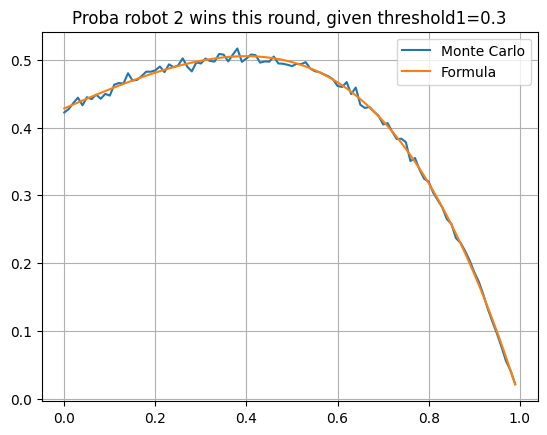

In [15]:
# Monte Carlo vs Theory on probability of winning one game

threshold1=.3

x_list = np.arange(0, 1, .01)

plt.plot(
    x_list,
    [get_monte_carlo_outcomes(n_simul=10000, threshold1=threshold1, threshold2=threshold)["p_robot_2_wins"] for threshold in x_list],
    label="Monte Carlo"
)
plt.plot(
    x_list,
    get_proba_game_outcomes(np.array([threshold1]*len(x_list)), x_list)["proba_robot_2_wins_this_round"],
    label="Formula"
)
plt.title(f"Proba robot 2 wins this round, given threshold1={threshold1}")
plt.grid()
plt.legend()
plt.show()

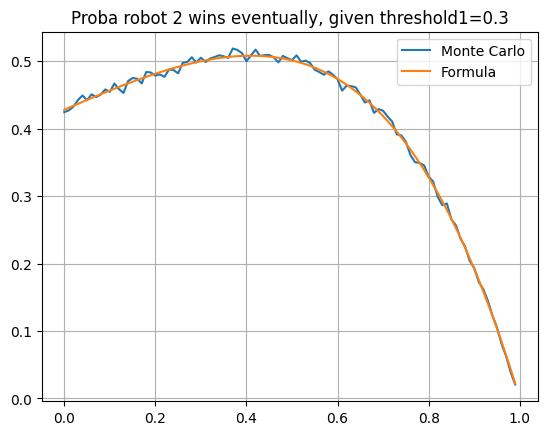

In [16]:
# Monte Carlo vs Theory on probability of winning eventually

threshold1=.3

x_list = np.arange(0, 1, .01)

plt.plot(
    x_list,
    [get_monte_carlo_outcomes_eventual(n_simul=10000, threshold1=threshold1, threshold2=threshold)["p_robot_2_wins_eventually"] for threshold in x_list],
    label="Monte Carlo"
)
plt.plot(
    x_list,
    get_proba_game_outcomes(np.array([threshold1]*len(x_list)), x_list)["proba_robot_2_wins_eventually"],
    label="Formula"
)
plt.title(f"Proba robot 2 wins eventually, given threshold1={threshold1}")
plt.grid()
plt.legend()
plt.show()

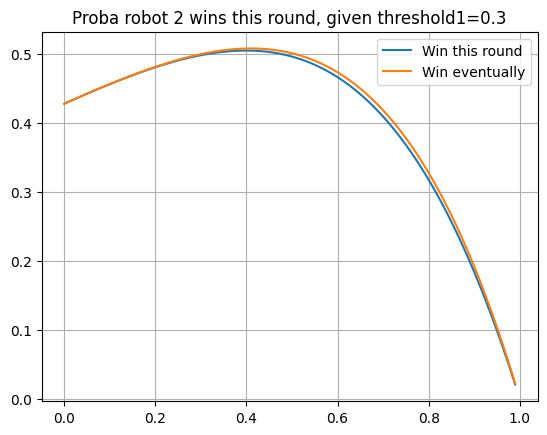

In [17]:
# Theory proba of winning a round vs eventually

threshold1=.3

x_list = np.arange(0, 1, .01)

plt.plot(
    x_list,
    get_proba_game_outcomes(np.array([threshold1]*len(x_list)), x_list)["proba_robot_2_wins_this_round"],
    label="Win this round"
)
plt.plot(
    x_list,
    get_proba_game_outcomes(np.array([threshold1]*len(x_list)), x_list)["proba_robot_2_wins_eventually"],
    label="Win eventually"
)
plt.title(f"Proba robot 2 wins this round, given threshold1={threshold1}")
plt.grid()
plt.legend()
plt.show()

# 3. Find Nash equilibrium

In [18]:
import scipy

def get_diff_func():
    x = sp.symbols('x')
    th1 = sp.symbols('th1', domain=sp.Interval(0, 1))
    th2 = sp.symbols('th2', domain=sp.Interval(0, 1))

    # Get proba of draw
    proba_draw = (1-(1-th1)*sp.exp(th1))*(1-(1-th2)*sp.exp(th2))

    # Get proba of winning one round
    expr1 = sp.simplify(
        (1-(1-th1)*sp.exp(th1))*(1-th2)*sp.exp(th2)
    )
    expr2 = sp.simplify(
        sp.factor(
            sp.integrate(
                sp.exp(th1)*(x-th1)*(1-th2)*sp.exp(th2),
                (x, th1, th2)
            )
        )
    )
    expr3 = sp.simplify(
        sp.integrate(
            -sp.exp(th1)*(x-th1)*sp.exp(th2)*(sp.Rational('1/2')*(x**2+th2**2)-th2*x+th2-1),
            (x, th2, 1)
        )
    )
    expr4 = sp.simplify(
        sp.integrate(
            -sp.exp(th1)*(1-th1)*sp.exp(th2)*(x-th2*x+sp.Rational('1/2')*(1+th2**2)-2+th2),
            (x, 1, 1+th1)
        )
    )
    expr5 = sp.simplify(
        sp.integrate(
            -sp.exp(th1)*(2-x)*sp.exp(th2)*(x-th2*x+sp.Rational('1/2')*(1+th2**2)-2+th2),
            (x, 1+th1, 1+th2)
        )
    )
    expr6 = sp.simplify(
        sp.integrate(
            -sp.exp(th1)*(2-x)*sp.exp(th2)*(2*x-sp.Rational('1/2')*x**2-2),
            (x, 1+th2, 2)
        )
    )
    proba_robot_2_wins_this_round = sp.simplify(
        expr1 + expr2 + expr3 + expr4 + expr5 + expr6
    )

    # Get proba of winning eventually
    proba_robot_2_wins_eventually = sp.simplify(proba_robot_2_wins_this_round / (1-proba_draw))

    # Differentiate it
    proba_robot_2_wins_diff_th2 = sp.simplify(sp.diff(proba_robot_2_wins_eventually, th2))
    return sp.lambdify([th1, th2], proba_robot_2_wins_diff_th2, "numpy")


diff_func = get_diff_func()
def get_optimal_threshold_given_threshold(other_threshold):
    sol = scipy.optimize.root_scalar(
        lambda th2: diff_func(other_threshold, th2),
        bracket=(0, 1),
        xtol=1e-10,
    )

    if sol.converged:
        return sol.root
    else:
        raise ValueError("Did not converge")

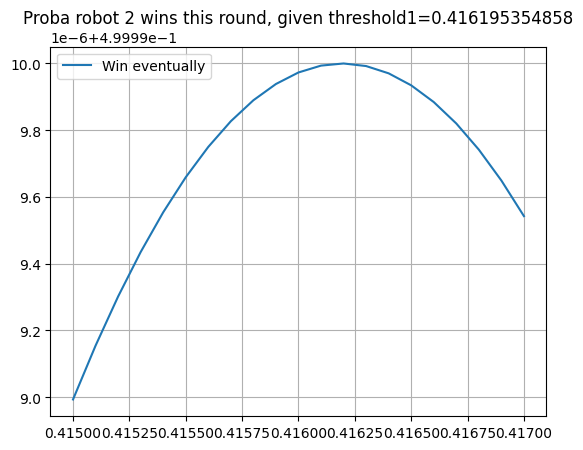

In [20]:
# Theory proba of winning a round vs eventually

threshold1=0.416195354858

x_list = np.arange(0.415, 0.417, .0001)

plt.plot(
    x_list,
    get_proba_game_outcomes(np.array([threshold1]*len(x_list)), x_list)["proba_robot_2_wins_eventually"],
    label="Win eventually"
)
plt.title(f"Proba robot 2 wins this round, given threshold1={threshold1}")
plt.grid()
plt.legend()
plt.show()

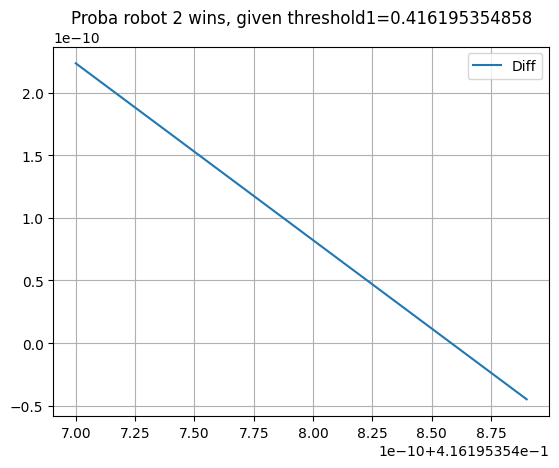

In [21]:
threshold1=0.416195354858

x_list = np.arange(0.4161953547, 0.4161953549, 1e-11)

plt.plot(
    x_list,
    diff_func(np.array([threshold1]*len(x_list)), x_list),
    label="Diff"
)
plt.title(f"Proba robot 2 wins, given threshold1={threshold1}")
plt.grid()
plt.legend()
plt.show()

# 4. Final solution

At optimal, we have:
- Robot 1 chooses to jump after it passes the threshold `0.41619535485814`
- Robot 2 chooses the same strategy (we see that it is optimal in the graph bellow)

In [23]:
optimal_threshold = 0.41619535485814

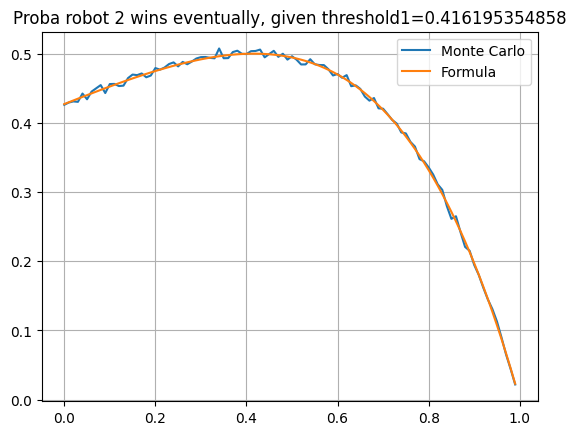

In [24]:
x_list = np.arange(0, 1, .01)

plt.plot(
    x_list,
    [get_monte_carlo_outcomes_eventual(n_simul=10000, threshold1=optimal_threshold, threshold2=threshold)["p_robot_2_wins_eventually"] for threshold in x_list],
    label="Monte Carlo"
)
plt.plot(
    x_list,
    get_proba_game_outcomes(np.array([optimal_threshold]*len(x_list)), x_list)["proba_robot_2_wins_eventually"],
    label="Formula"
)
plt.title(f"Proba robot 2 wins eventually, given threshold1={threshold1}")
plt.grid()
plt.legend()
plt.show()

This corresponds to the following end-game probabilities

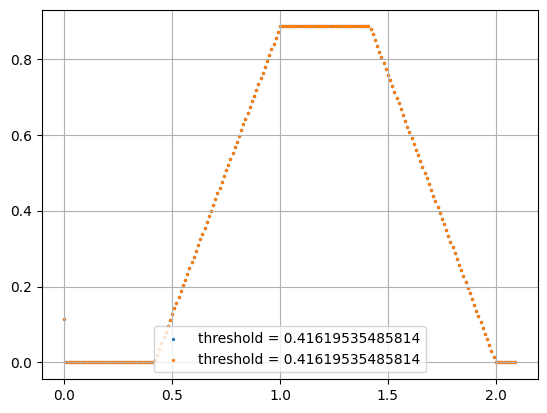

Proba of failed game: 0.1148458859812802


In [25]:
plt.scatter(
    np.arange(0, 2.1, .01),
    [get_theoretical_end_proba(x, threshold=optimal_threshold)  for x in np.arange(0, 2.1, .01)],
    label=f"threshold = {optimal_threshold}",
    s=2,  
)

plt.scatter(
    np.arange(0, 2.1, .01),
    [get_theoretical_end_proba(x, threshold=optimal_threshold)  for x in np.arange(0, 2.1, .01)],
    label=f"threshold = {optimal_threshold}",
    s=2,  
)

plt.legend()
plt.grid()
plt.show()

print(f"Proba of failed game: {get_theoretical_end_proba(x=0, threshold=optimal_threshold)}")

In [26]:
round(get_theoretical_end_proba(x=0, threshold=optimal_threshold), 9)